In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
import matplotlib

from brokenaxes import brokenaxes


In [5]:
plt.rcParams.update({
    # Fonts - Times, 8-12 pt
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times"],
    "font.size": 12,                  # Base size 8-12 pt

    # Axes
    "axes.titlesize": 12,             # Axis title size
    "axes.labelsize": 12,             # Axis label size
    "axes.labelweight": "normal",     # Normal weight
    "axes.titleweight": "normal",     # Normal weight for titles

    # Ticks
    "xtick.labelsize": 8,             # X tick label size (8-12)
    "ytick.labelsize": 8,             # Y tick label size (8-12)
    "xtick.direction": "in",          # Tick direction
    "ytick.direction": "in",          # Tick direction

    # Legends
    "legend.fontsize": 10,            # Legend text size (8-12)
    "legend.title_fontsize": 10,      # Legend title size (8-12)
    "legend.loc": 'best',             # Automatic location

    # Resolution
    "figure.dpi": 500,                # Display DPI
    "savefig.dpi": 500,               # Save DPI (300-600)
    "savefig.bbox": "tight",          # Crop whitespace

    # Without LaTeX
    "text.usetex": False,             # PLOS does not accept LaTeX EPS
    "mathtext.fontset": "dejavuserif",# Match math fonts to serif
})


In [15]:
v_rest = [-22, -17, -12.3, -8.5]
cmap = plt.cm.Reds
vrest_sorted = sorted(v_rest)
colors_sorted = [cmap(x) for x in np.linspace(0.25, 1, len(v_rest))]
color_map = {vr: c for vr, c in zip(vrest_sorted, colors_sorted)}

In [16]:
import numpy as np

# Parámetros de simulación
T = 1000
dt = 0.1
sigman = 0.0
v_threshold = 0
v_rest = [-12.3]

def dynamics(x, I, tipo):
    if tipo == "LIF":
        dx = -x + I + np.random.randn() * sigman
    elif tipo == "QIF":
        dx = 1 - np.cos(x) + I * (1 + np.cos(x)) + np.random.randn() * sigman
    return dx

def detect(x_old, x_new, tipo, vt, vrest):
    spike = False
    if tipo == "LIF":
        if x_old < vt and x_new > vt:
            spike = True
            x_new = vrest
    elif tipo == "QIF":
        dpi = (np.pi - (x_old % (2*np.pi))) % (2*np.pi)
        if (x_new - x_old) > dpi:
            spike = True
    return x_new, spike

def simulate_single_cell(I, tipo, vt=None, vrest=0):
    x = vrest
    spikes = 0
    for _ in range(T):
        dx = dynamics(x, I, tipo)
        x_new = x + dt * dx
        x_new, spike = detect(x, x_new, tipo, vt, vrest)
        if spike:
            spikes += 1
        x = x_new
    return spikes / (T / 1000)  # frecuencia en Hz

# Corrientes
I_vals = np.linspace(-1, 6, 10)
I_qif = np.linspace(-1,6, 10)

# Guardar frecuencias LIF
freqs_lif = {}
for vrest_value in v_rest:
    freqs = np.array([simulate_single_cell(I, "LIF", v_threshold, vrest=vrest_value) for I in I_vals])
    freqs_lif[vrest_value] = freqs

# Guardar frecuencias QIF
freqs_qif = np.array([simulate_single_cell(I, "QIF") for I in I_qif])

# Guardar todo en un archivo npz
np.savez('fi_data.npz', I_vals=I_vals, v_rest=v_rest, freqs_lif=freqs_lif, I_qif=I_qif, freqs_qif=freqs_qif)
print("Datos guardados en 'fi_data.npz'")


Datos guardados en 'fi_data.npz'


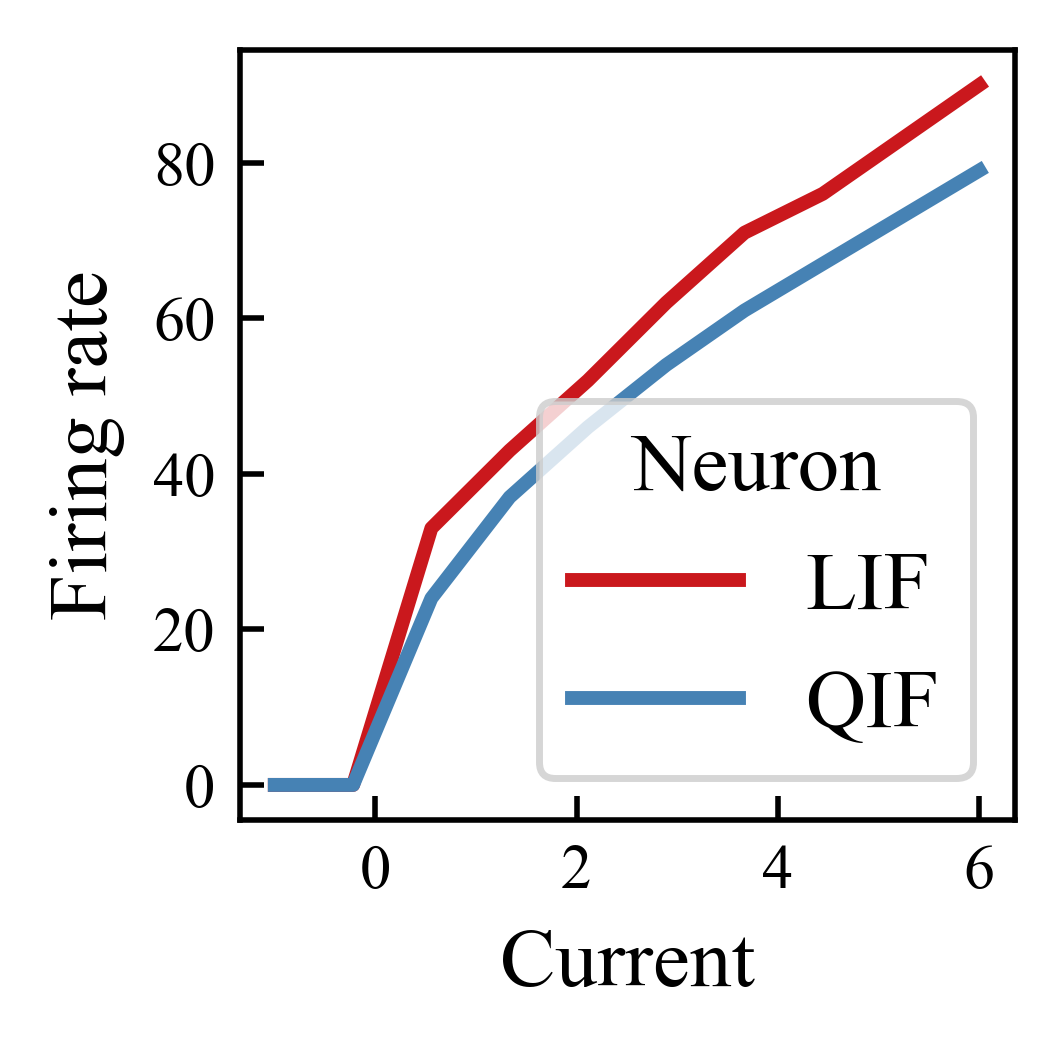

In [17]:
# Cargar datos
data = np.load('fi_data.npz', allow_pickle=True)
I_vals = data['I_vals']
v_rest = data['v_rest']
freqs_lif = data['freqs_lif'].item()  # dict
I_qif = data['I_qif']
freqs_qif = data['freqs_qif']

# Colores

vrest_sorted = sorted(v_rest)

fig, ax = plt.subplots(figsize=(2,2))  # figura grande



# Graficar LIF
handles_dict = {}
labels_dict = {}
slopes_dict = {}


vrest_value = -12.3

freqs = freqs_lif[vrest_value]
mask = I_vals > -1
coef, cov = np.polyfit(I_vals[mask], freqs[mask], 1, cov=True)
pendiente = coef[0]
slopes_dict[vrest_value] = pendiente
pendiente_err = np.sqrt(cov[0,0])



line, = ax.plot(I_vals, freqs, '-', color=color_map[vrest_value], linewidth=2, label = 'LIF')
#ax.plot(I_vals[mask], np.polyval(coef, I_vals[mask]), ':', lw=3, color=color_map[vrest_value])
    


coef_qif, cov_qif = np.polyfit(I_qif, freqs_qif, 1, cov=True)
pendiente_qif = coef_qif[0]
slopes_dict['QIF'] = pendiente_qif
pendiente_qif_err = np.sqrt(cov_qif[0,0])

line_qif, = ax.plot(I_qif, freqs_qif, '-', color='steelblue', linewidth=2, label = 'QIF')
#ax.plot(I_qif[mask_qif], np.polyval(coef_qif, I_qif[mask_qif]), ':', lw=3, color='steelblue')


# Labels ejes
ax.set_xlabel("Current")
ax.set_ylabel("Firing rate ")
ax.tick_params(axis='both', direction='in')
ax.legend(title = 'Neuron')
plt.savefig('a_fi_curve.svg', dpi=200)


plt.show()

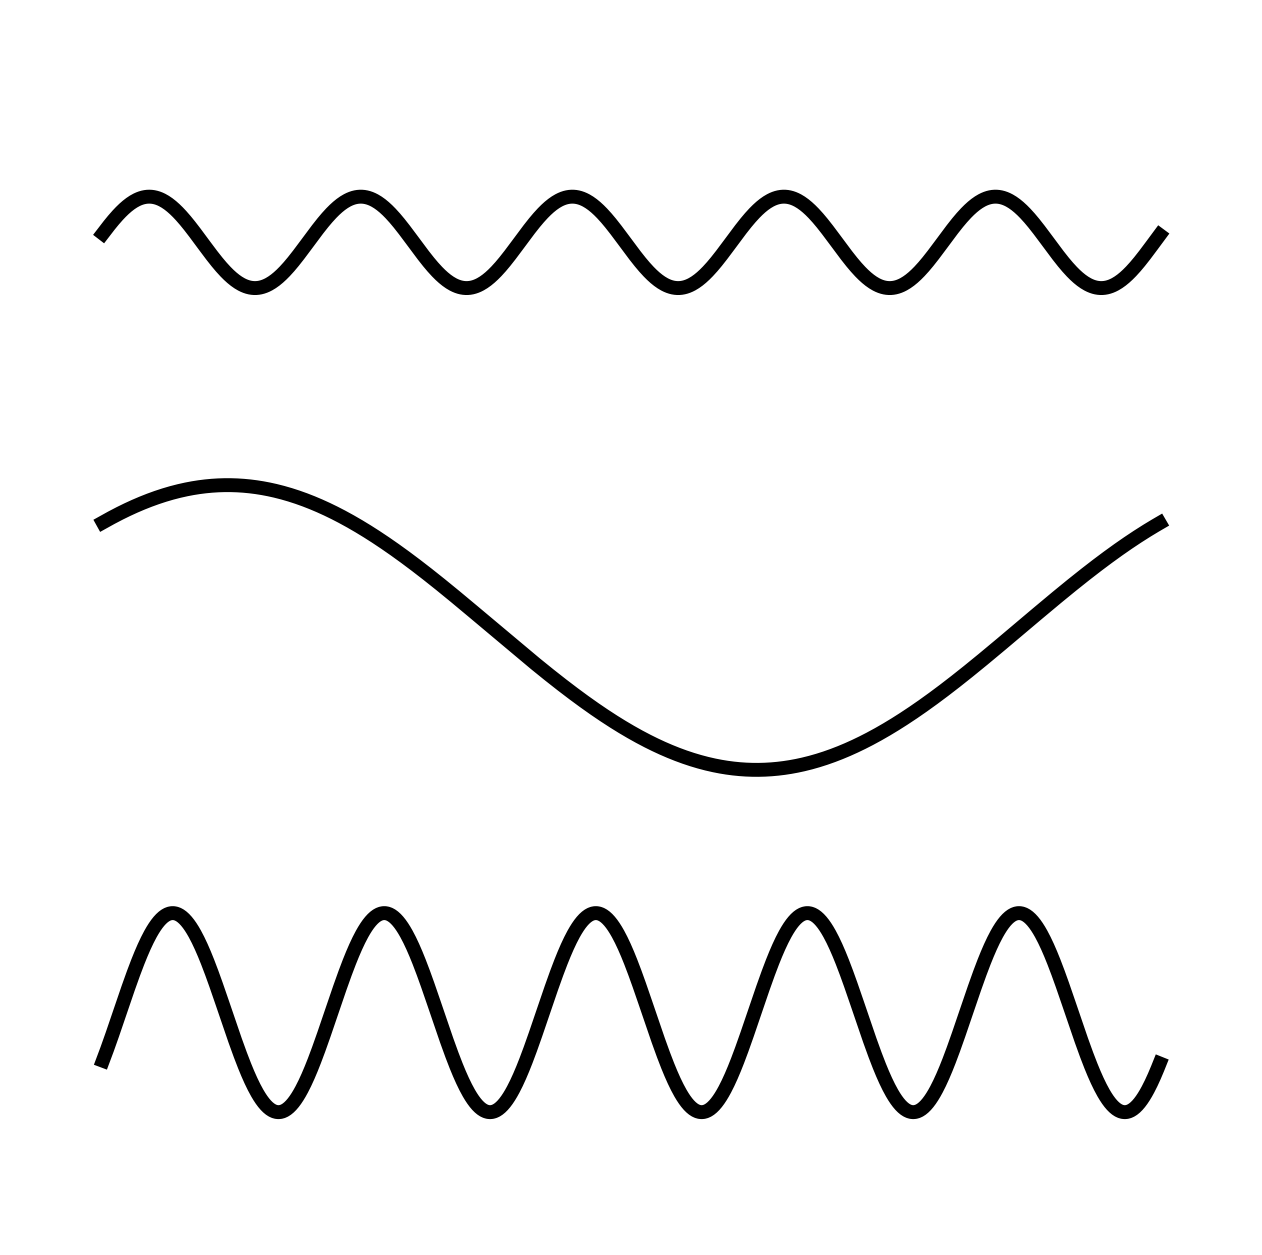

In [18]:
# Cargar el CSV
archivo = r"C:\Users\aceve\Desktop\HeterogeneousRNNs\post_training\Figure1\simulation_1\simulation_1_targets_1.csv"
df = pd.read_csv(archivo)

# Elegir las primeras cinco neuronas
neuronas = df.columns[13:16]
datos = df[neuronas]

# Encontrar el rango global de amplitud para todas las neuronas
y_min_global = datos.min().min()
y_max_global = datos.max().max()

# Crear figura
fig, axs = plt.subplots(len(neuronas), 1, sharex=True, figsize=(3, 3))
plt.subplots_adjust(hspace=0.001)


for i, neurona in enumerate(neuronas):
    axs[i].plot(datos[neurona], color='black', linewidth=2)
    
    # Usar la misma escala para todas
    axs[i].set_ylim(y_min_global-1, y_max_global+1)
    
    # Quitar todos los ejes
    axs[i].axis('off')



plt.savefig('c_oscillations_draw.svg', dpi=500)
plt.show()

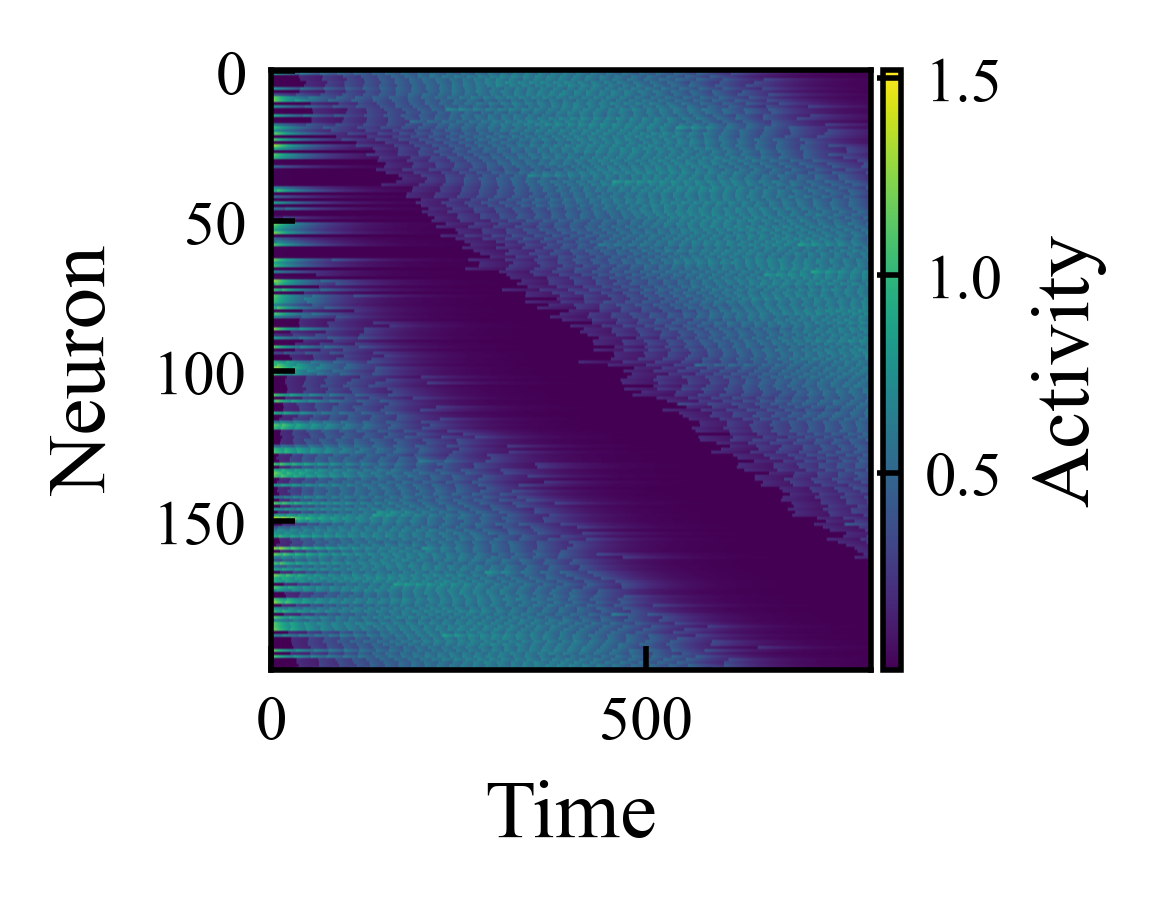

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

idx = 3
pqif = 1
iloop = 14

# Cargar datos
target = pd.read_csv(f'simulation_{idx}/simulacion_{idx}_targets_{pqif}.csv').values
inputs = pd.read_csv(
    f'simulation_{idx}/simulation_{idx}_inputs/simulation_{idx}_inputs_pqif_{pqif}_iloop_{iloop}_seed_0.csv',
    header=None
).values
outputs = pd.read_csv(
    f'simulation_{idx}/simulation_{idx}_outputs/simulation_{idx}_outputs_pqif_{pqif}_iloop_{iloop}_seed_0.csv',
    header=None
).values
pretrain_inputs = pd.read_csv(
    f'simulation_{idx}/simulation_{idx}_inputs/simulation_{idx}_inputs_pqif_{pqif}_iloop_0_seed_0.csv',
    header=None
).values

# Ignorar primeros 200 ms
inputs_rest = np.nan_to_num(inputs[200:, :])
target_rest = np.nan_to_num(target[200:, :])
pretrain_rest = np.nan_to_num(pretrain_inputs[200:, :])
outputs_rest = np.nan_to_num(outputs[200:, :])

# Colormap compartido
vmin = min(pretrain_rest.min(), inputs_rest.min(), target_rest.min())
vmax = max(pretrain_rest.max(), inputs_rest.max(), target_rest.max())

vmin_target = target_rest.min()
vmax_target = target_rest.max()

# Tamaño del colormap cuadrado
square_size = 1.2

# Crear figura y axes manualmente
fig = plt.figure(figsize=(square_size , square_size ))

# Posición del axes principal: [left, bottom, width, height] en fracción de figura
ax = fig.add_axes([0.15, 0.12, square_size/fig.get_figwidth(), square_size/fig.get_figheight()])

# Target
im = ax.imshow(outputs_rest.T, cmap='viridis', aspect='auto')

ax.set_xlabel('Time')
ax.set_ylabel('Neuron')

# Colorbar vertical al costado, alineada con el axes
pos = ax.get_position()
cbar_ax = fig.add_axes([pos.x1 + 0.02, pos.y0, 0.03, pos.height])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('Activity')


plt.savefig('6_outputs_sequence.svg', dpi=500)


In [20]:
N = 200
itmax = 1000
itstim = 200
nloop = 16
ult_loop = 15


(1000, 200)
(1000, 200)
(1000, 200)
(1000, 200)
(1000, 200)
(1000, 200)


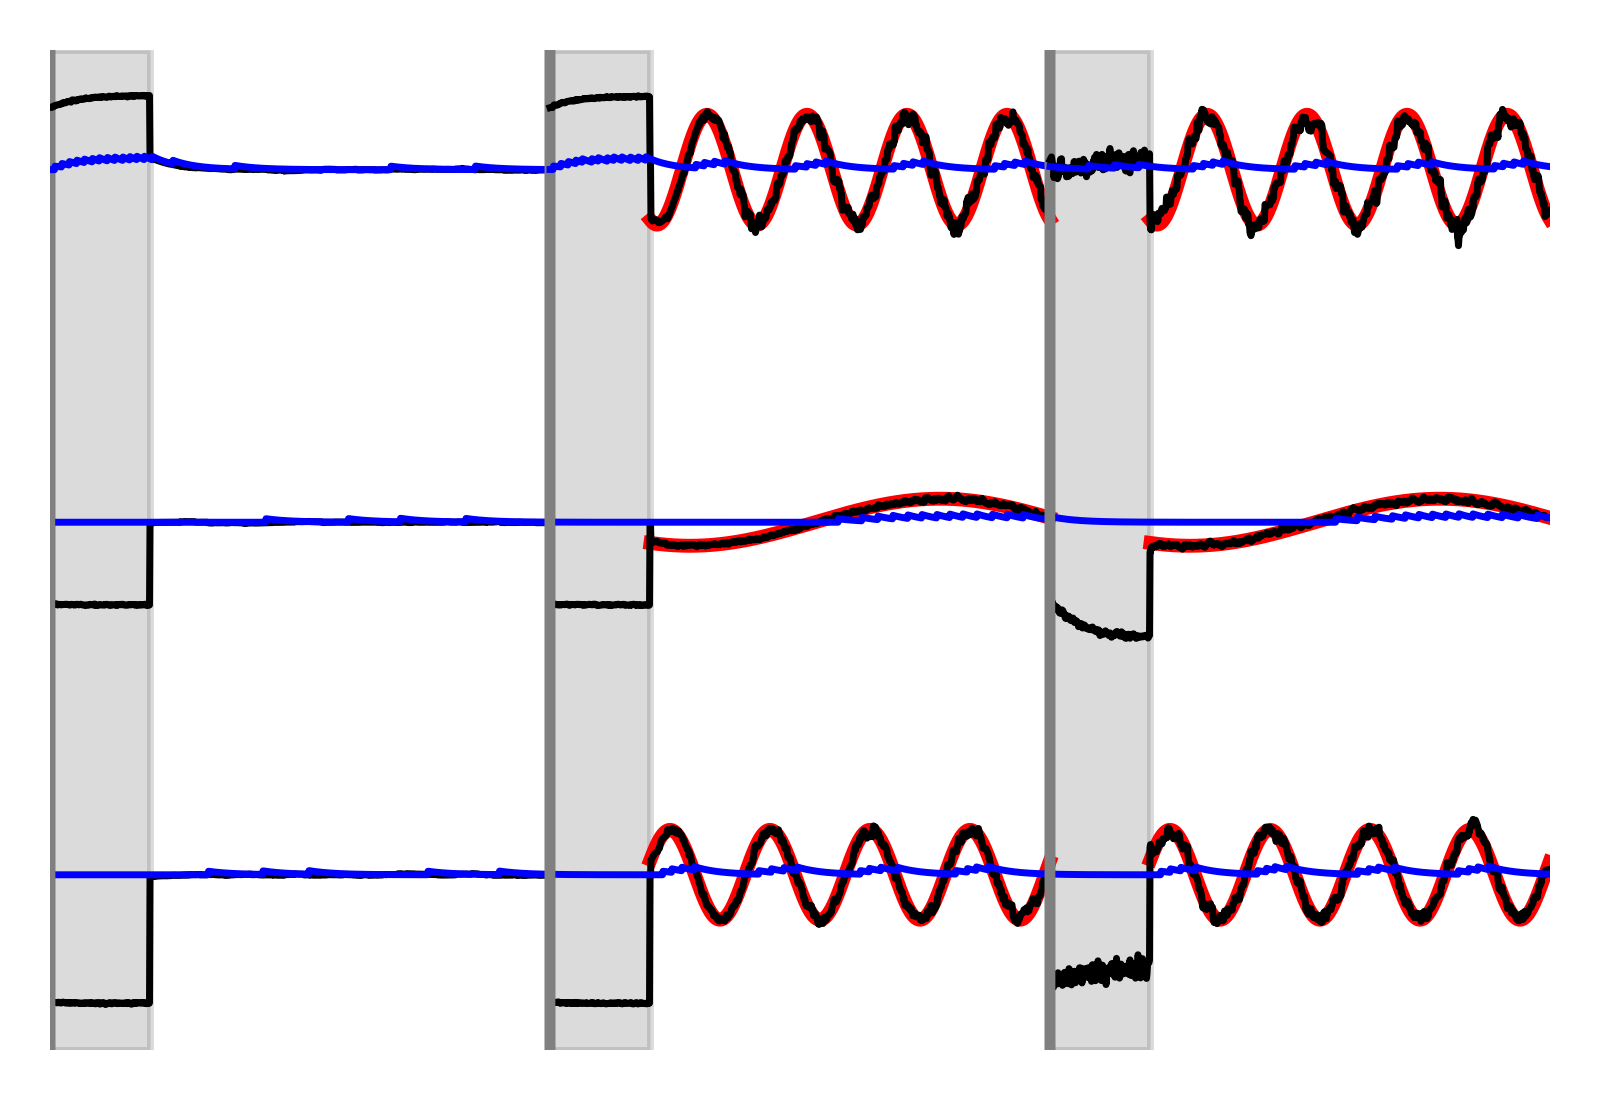

(1000, 200)
(1000, 200)


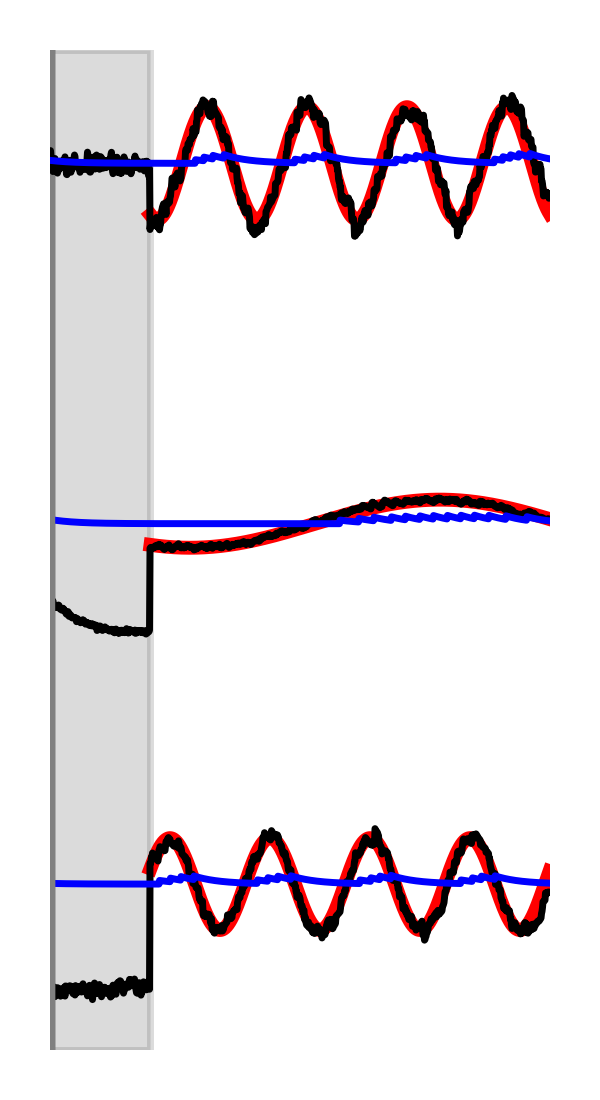

<Figure size 500x1000 with 0 Axes>

In [21]:
iloop_vect = [0,1,2,11]
pqif = 1
idx = 1

plt.figure(figsize=(3, 2))
for iloop in iloop_vect:
    target_csv = pd.read_csv(f'simulation_{idx}/simulation_{idx}_targets_{pqif}.csv')
    targets = target_csv.values

    inputs_csv = pd.read_csv(f'simulation_{idx}/simulation_{idx}_inputs/simulation_{idx}_inputs_pqif_{pqif}_iloop_{iloop}_seed_0.csv', header=None)
    inputs = inputs_csv.values
    print(inputs.shape)
    outputs_csv = pd.read_csv(f'simulation_{idx}/simulation_{idx}_outputs/simulation_{idx}_outputs_pqif_{pqif}_iloop_{iloop}_seed_0.csv', header=None)
    outputs = outputs_csv.values
    print(outputs.shape)
    for i in range(16,19):

        input_i = inputs[:, i]
        target_i = targets[:, i]

        # Agregar la región sombreada entre x=0 y x=200
        shaded_start = itmax * iloop
        shaded_end = shaded_start + 200  # 200 unidades después
        plt.axvspan(shaded_start, shaded_end, color='gray', alpha=0.1)

        plt.axvline(x=iloop * itmax, color='gray')

        # Graficar la línea roja del target solo fuera del área sombreada
        if iloop != 0:
            x_vals = np.arange(0, itmax) +itmax * iloop
            target_plot = (x_vals < shaded_start) | (x_vals > shaded_end)  # Fuera del área sombreada
            plt.plot(x_vals[target_plot], (target_i + i*20)[target_plot], color='r', linewidth=2)

        # Graficar siempre la línea negra del input
        plt.plot(np.arange(0, itmax) + itmax * iloop, input_i + i*20, color='black', linewidth=1)
        plt.plot(np.arange(0, itmax) + itmax * iloop, outputs[:, i] + i*20, color='blue', linewidth=1)
    if iloop == 2 or iloop == 11:
        plt.axis('off')
        plt.tight_layout(pad=0)
        if iloop == 2:
            plt.xlim(0, itmax + iloop * itmax)
        else:
            plt.xlim(11 * itmax, 12 * itmax)

        plt.savefig(f'e_oscillationsKC_iloop_{iloop}.svg', bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.figure(figsize=(1, 2))



C:\Users\aceve\AppData\Local\Temp\ipykernel_25020\2973686260.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


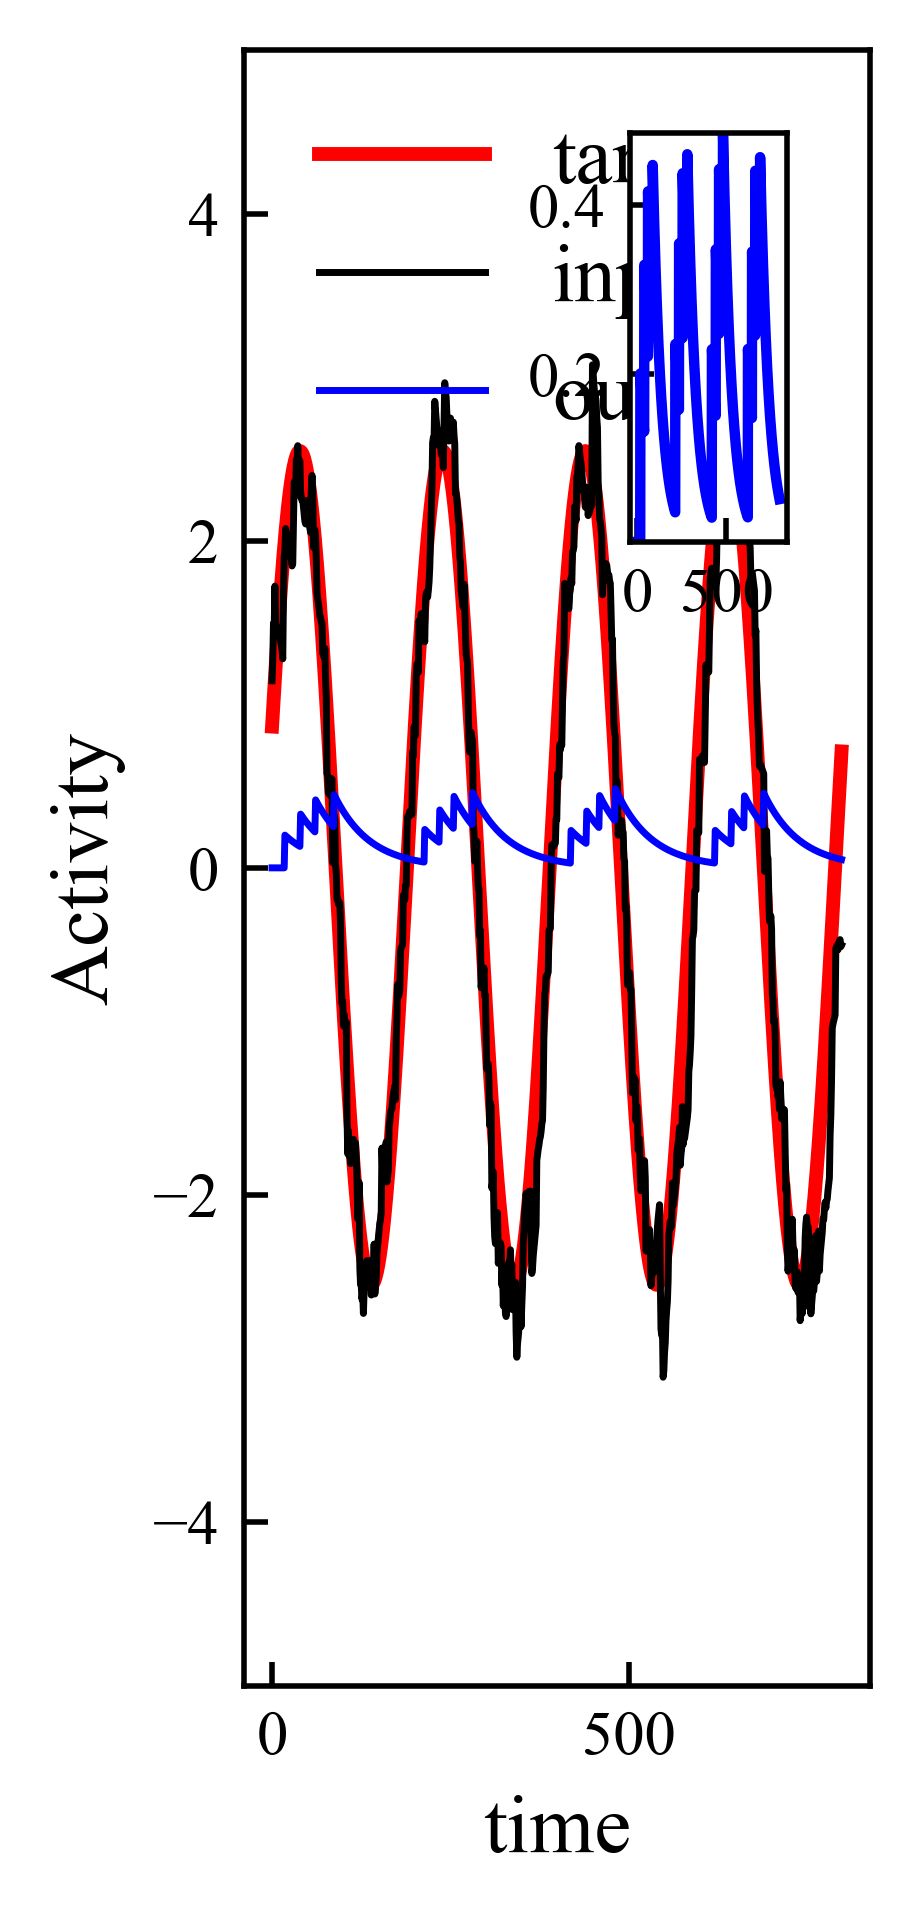

In [22]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

iloop = 11
pqif = 1
idx = 1
i = 16          # neurona a graficar
itmax=1000
fig, ax = plt.subplots(figsize=(2, 4))  # figura cuadrada

# -----------------------
# Cargar datos
# -----------------------
target_csv = pd.read_csv(f'simulation_{idx}/simulation_{idx}_targets_{pqif}.csv')
targets = target_csv.values

inputs_csv = pd.read_csv(
    f'simulation_{idx}/simulation_{idx}_inputs/simulation_{idx}_inputs_pqif_{pqif}_iloop_{iloop}_seed_0.csv',
    header=None
)
inputs = inputs_csv.values

outputs_csv = pd.read_csv(
    f'simulation_{idx}/simulation_{idx}_outputs/simulation_{idx}_outputs_pqif_{pqif}_iloop_{iloop}_seed_0.csv',
    header=None
)
outputs = outputs_csv.values

input_i = inputs[:, i]
target_i = targets[:, i]
output_i = outputs[:, i]

# -----------------------
# Eje temporal
# -----------------------
itstim = np.arange(itmax)
x_vals = itstim + itmax * iloop

# Máscara: solo itstim > 200
mask = itstim > 200

# -----------------------
# Plot principal
# -----------------------
ax.plot(

    target_i[mask],
    color='r',
    linewidth=2,
    label='target'
)

ax.plot(

    input_i[mask],
    color='black',
    linewidth=1,
    label='input'
)

ax.plot(

    output_i[mask],
    color='blue',
    linewidth=1,
    label='output'
)

# -----------------------
# Ejes principales
# -----------------------

ax.set_xlabel('time')
ax.set_ylabel('Activity')
ax.legend(frameon=False, loc ='upper left')
ax.set_ylim(-5,5)

# ==================================================
# INSET: zoom del output (itstim > 200)
# ==================================================
axins = inset_axes(
    ax,
    width="25%",
    height="25%",
    loc="upper right",
    borderpad=1
)

axins.plot(
    output_i[mask],
    color='blue',
    linewidth=1.5
)



axins.set_ylim(
    output_i[mask].min(),
    output_i[mask].max()
)


# -----------------------
plt.tight_layout()
plt.savefig('e_ejemplo_oscillationsKC_iloop_11_itstim_gt_200.svg')

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


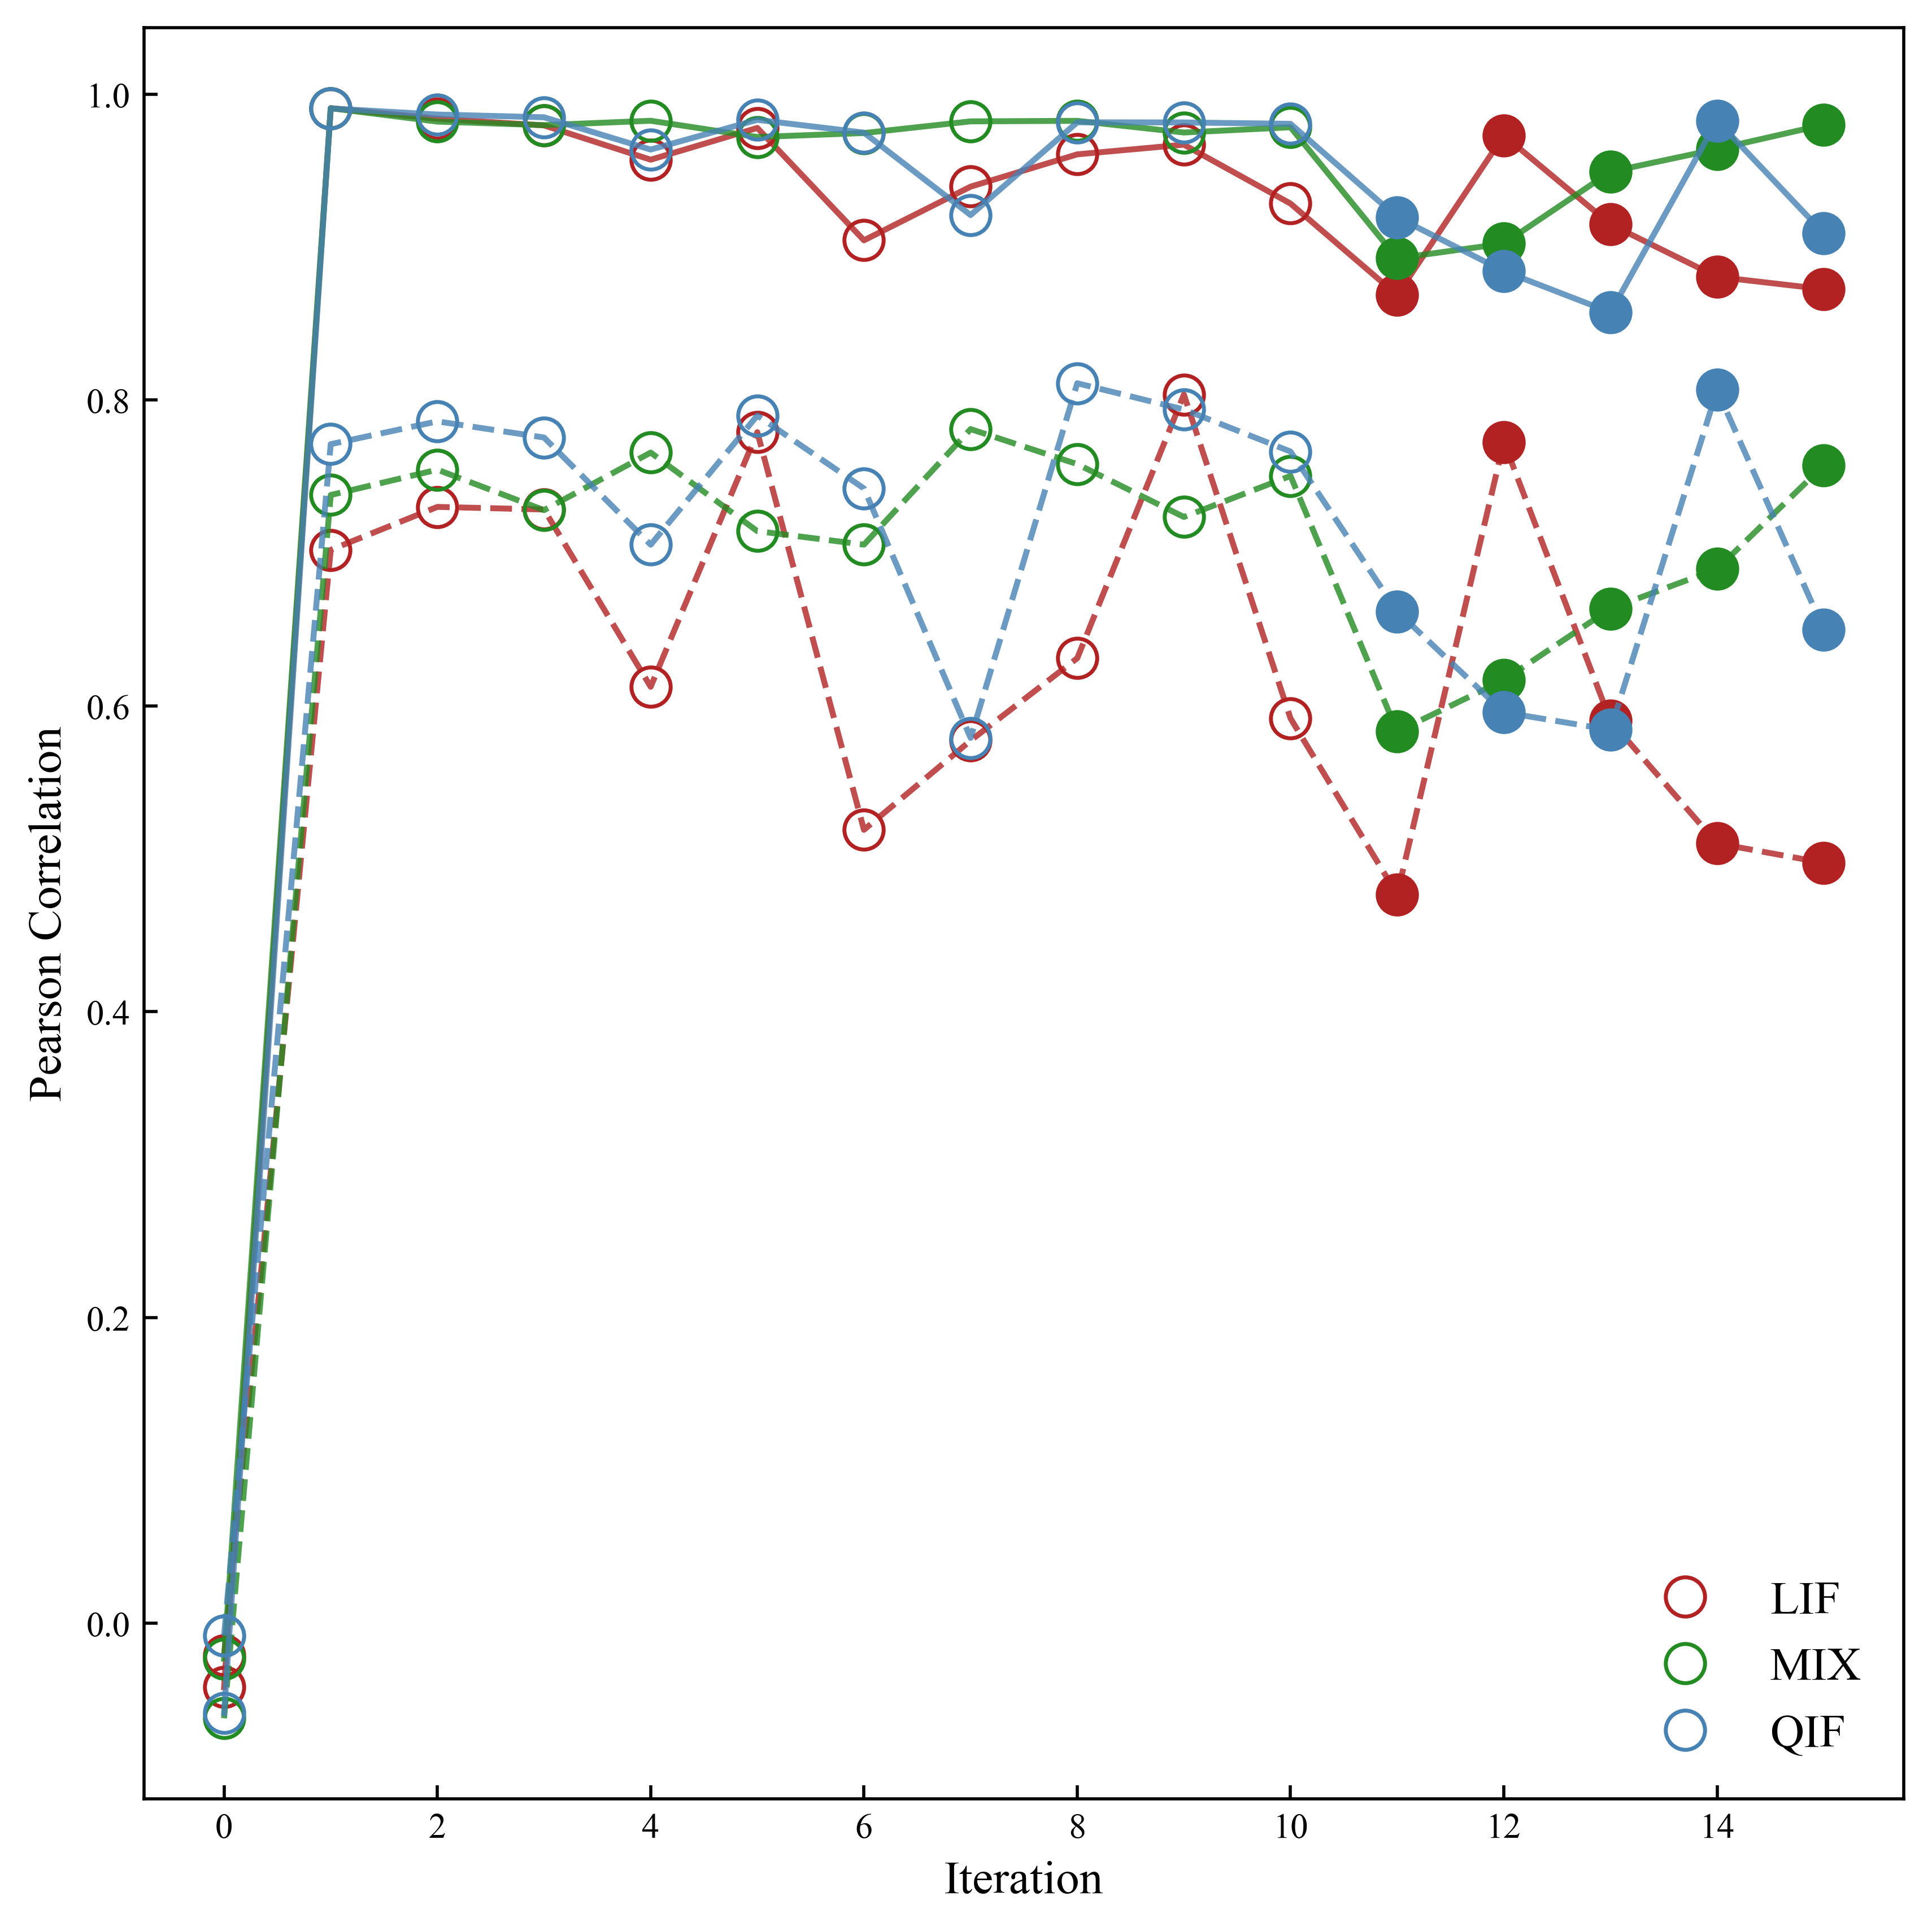

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# ------------------------
# Parámetros
# ------------------------
idx = 3  # Oscillations
xs = [0, 0.5, 1]
colores = ['firebrick', 'forestgreen', 'steelblue']
nombres = ['LIF', 'MIX', 'QIF']

N = 200
itstim = 200
nloop = 16

# ------------------------
# Figura
# ------------------------
plt.figure(figsize=(7, 7))
ax = plt.gca()

for x, color, nombre in zip(xs, colores, nombres):

    # ------------------------
    # Targets
    # ------------------------
    target_csv = pd.read_csv(
        f'simulation_{idx}/simulacion_{idx}_targets_{x}.csv'
    )
    targets = target_csv.values

    # ------------------------
    # Pearson TARGET vs INPUTS (entrenamiento)
    # ------------------------
    cc = np.zeros(nloop)

    for iloop in range(nloop):
        file_in = (
            f'simulation_{idx}/simulation_{idx}_inputs/'
            f'simulation_{idx}_inputs_pqif_{x}_iloop_{iloop}_seed_0.csv'
        )
        df_in = pd.read_csv(file_in, header=None).values

        ci = np.zeros(N)
        for i in range(N):
            rout_i = df_in[:, i]
            if np.var(targets[itstim:, i]) > 0 and np.var(rout_i[itstim:]) > 0:
                ci[i] = pearsonr(
                    targets[itstim:, i],
                    rout_i[itstim:]
                )[0]

        cc[iloop] = np.mean(ci)

    # Línea continua (inputs)
    ax.plot(
        np.arange(nloop),
        cc,
        color=color,
        linewidth=1.5,
        alpha=0.8
    )

    # Train (huecos)
    ax.plot(
        np.arange(1, 11),
        cc[1:11],
        'o',
        markersize=10,
        markerfacecolor='none',
        color=color
    )

    # Test (llenos)
    ax.plot(
        np.arange(11, 16),
        cc[11:],
        'o',
        markersize=10,
        markerfacecolor=color,
        color=color
    )

    # Iteración 0
    ax.plot(
        0,
        cc[0],
        'o',
        markersize=10,
        markerfacecolor='none',
        color=color,
        label=nombre
    )

    # ------------------------
    # Pearson TARGET vs OUTPUTS
    # ------------------------
    cc_out = np.zeros(nloop)
    for iloop in range(nloop):
        file_out = (
            f'simulation_{idx}/simulation_{idx}_outputs/'
            f'simulation_{idx}_outputs_pqif_{x}_iloop_{iloop}_seed_0.csv'
        )
        df_out = pd.read_csv(file_out, header=None).values

        ci_out = np.zeros(N)
        for i in range(N):
            rout_i = df_out[:, i]
            if np.var(targets[itstim:, i]) > 0 and np.var(rout_i[itstim:]) > 0:
                ci_out[i] = pearsonr(
                    targets[itstim:, i],
                    rout_i[itstim:]
                )[0]

        cc_out[iloop] = np.mean(ci_out)


    # Línea continua (inputs)
    ax.plot(
        np.arange(nloop),
        cc_out,
        color=color,
        linestyle='--',
        linewidth=1.5,
        alpha=0.8
    )


    # Train (huecos)
    ax.plot(
        np.arange(1, 11),
        cc_out[1:11],
        'o',
        markersize=10,
        markerfacecolor='none',
        color=color
    )



    # Test (llenos)
    ax.plot(
        np.arange(11, 16),
        cc_out[11:],
        'o',
        markersize=10,
        markerfacecolor=color,
        color=color

    )

    # Iteración 0
    ax.plot(
        0,
        cc_out[0],
        'o',
        markersize=10,
        markerfacecolor='none',
        color=color,

    )


# ------------------------
# Estética final
# ------------------------
ax.set_xlabel('Iteration')
ax.set_ylabel('Pearson Correlation')

ax.legend(frameon=False)

plt.tight_layout()
plt.savefig('pearson_oscillations_idx1.eps')
plt.savefig('pearson_oscillations_idx1.svg')
plt.show()


(790, 2)
7.99 0.01


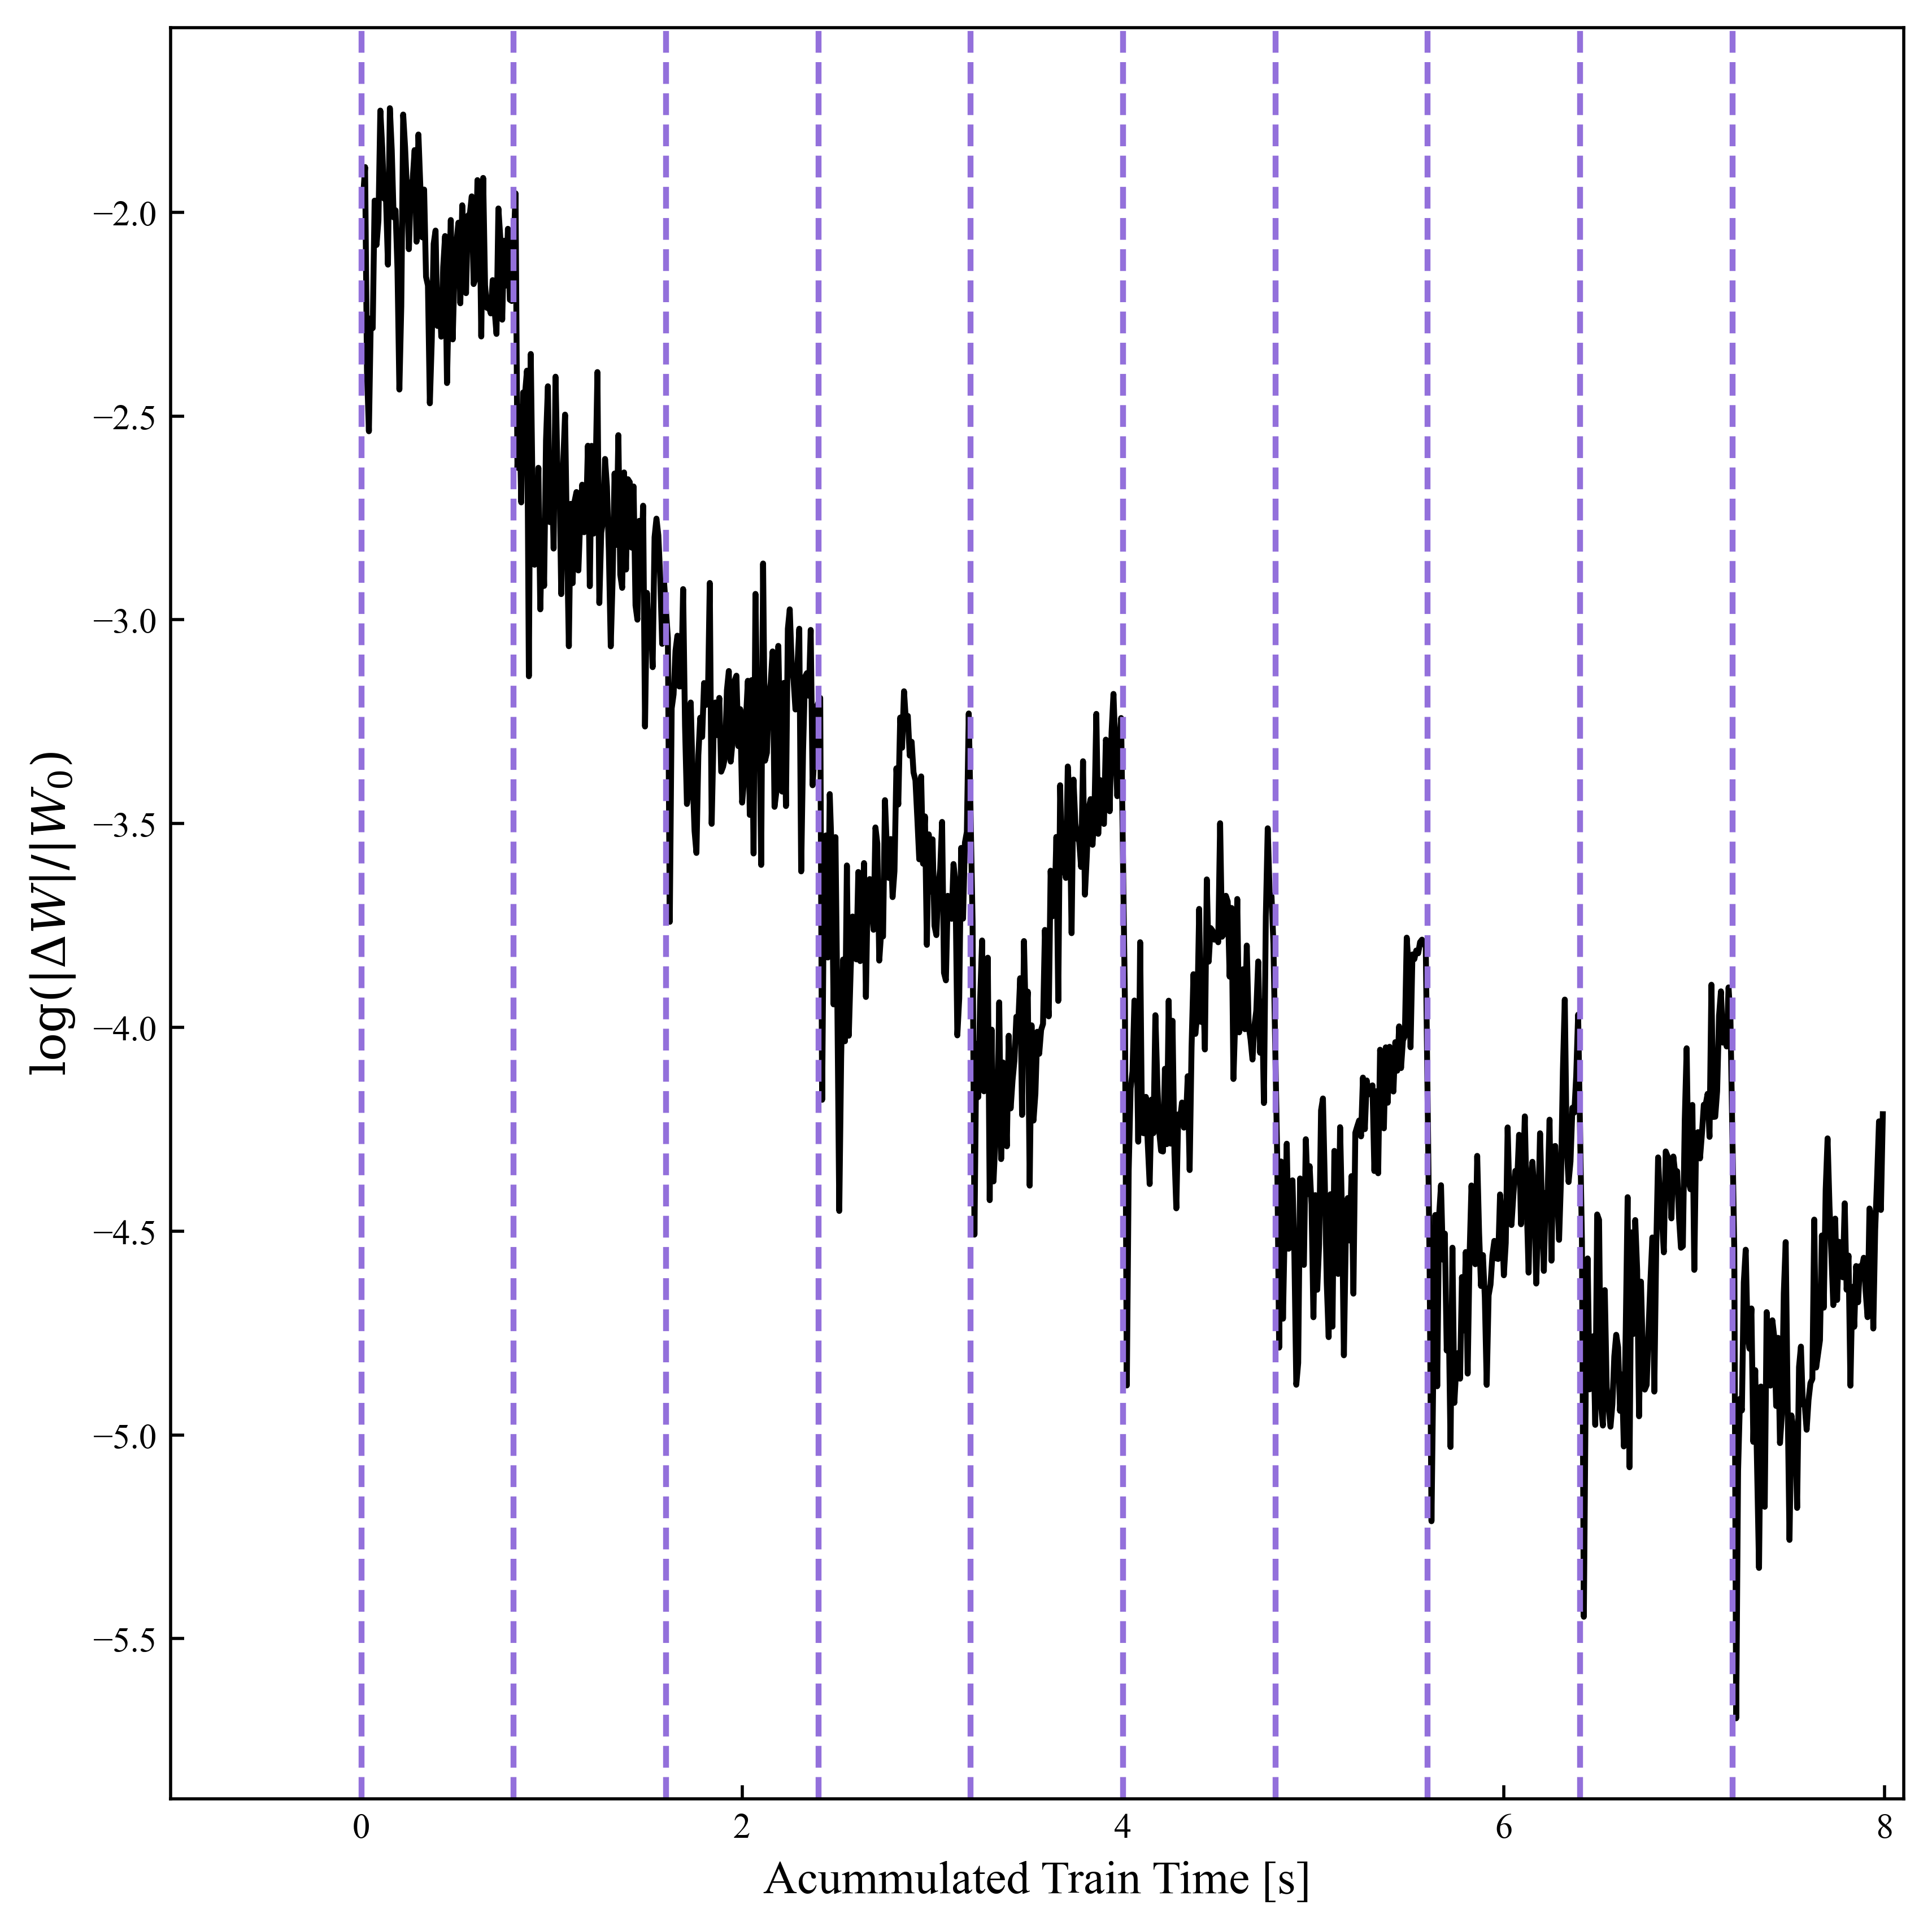

In [24]:

dw_csv = pd.read_csv(f'simulation_{idx}/simulation_{idx}_dw_pqif_0.5_seed_0.csv')
dw_dt = dw_csv.values
print(dw_dt.shape)

plt.figure(figsize=(7,7))
plt.plot(dw_dt[:, 0]/1000, dw_dt[:, 1], color = 'black')
plt.ylabel(r'$\log (|\Delta W|/|W_0)$')
plt.xlabel('Acummulated Train Time [s]')
plt.tight_layout()

for i in range(10):
    plt.axvline(x = i*0.8, color = 'mediumpurple',  linestyle = '--')
print(np.max(dw_dt[:, 0]/1000), np.min(dw_dt[:, 0]/1000))
plt.xlim(-1, 8.1)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


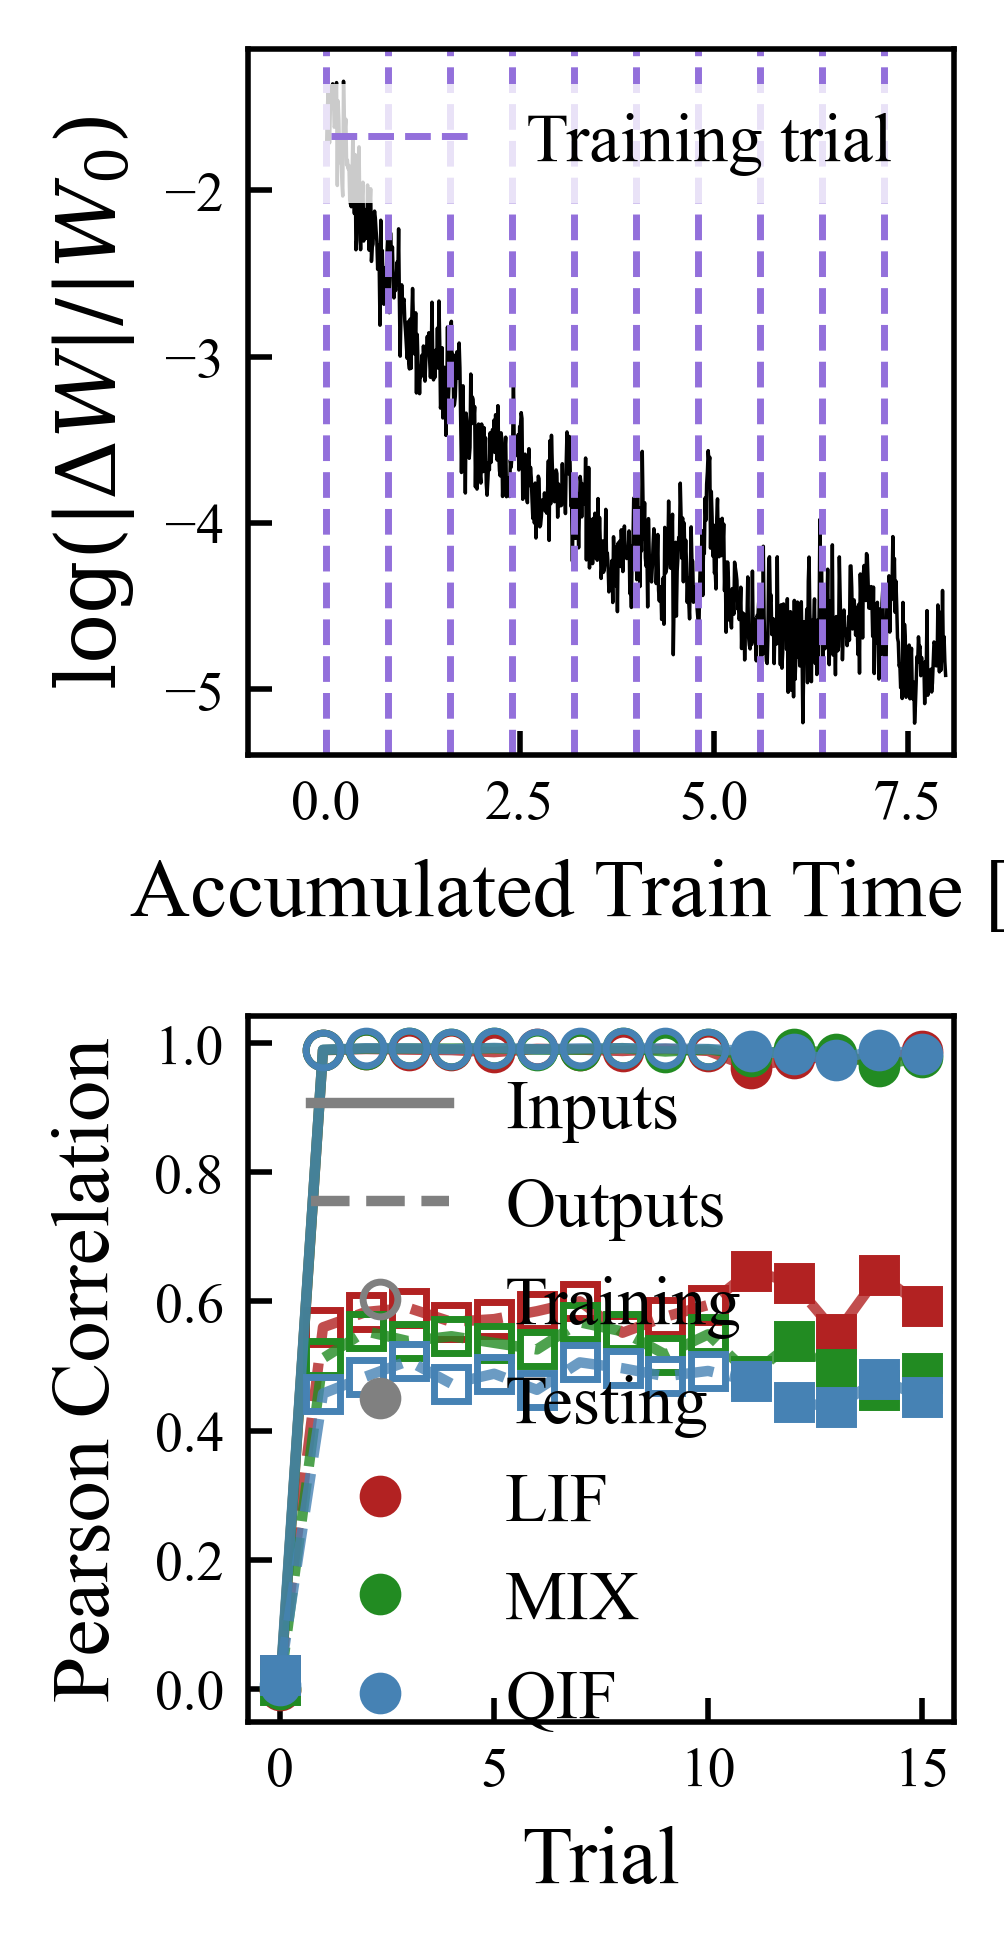

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# ------------------------
# Parámetros
# ------------------------
idx = 1  # Oscillations
xs = [0, 0.5, 1]
colores = ['firebrick', 'forestgreen', 'steelblue']
nombres = ['LIF', 'MIX', 'QIF']

N = 200
itstim = 200
nloop = 16

# ------------------------
# Figura con dos subplots
# (cuadrados y del mismo tamaño)
# ------------------------
fig, axes = plt.subplots(
    2, 1,
    figsize=(2,4),   # alto = 2 × ancho
    sharex=False
)

# Forzar recuadros cuadrados idénticos
for ax in axes:
    ax.set_box_aspect(1)

# ============================================================
# Subplot superior: dW/dt
# ============================================================
from matplotlib.lines import Line2D

ax_dw = axes[0]

dw_csv = pd.read_csv(
    f'simulation_{idx}/simulation_{idx}_dw_pqif_0.5_seed_0.csv'
)
dw_dt = dw_csv.values

ax_dw.plot(
    dw_dt[:, 0] / 1000,
    dw_dt[:, 1],
    color='black',
    linewidth=0.5,
)

# Violet lines indicate training trials
for i in range(10):
    ax_dw.axvline(
        x=i * 0.8,
        color='mediumpurple',
        linestyle='--',
        linewidth=1,
    )

ax_dw.set_xlim(-1, 8.1)
ax_dw.set_ylabel(r'$\log (|\Delta W|/|W_0)$')
ax_dw.set_xlabel('Accumulated Train Time [s]')

# ------------------------
# Leyenda para las líneas violetas con fondo blanco
# ------------------------
training_line = Line2D([0], [0], color='mediumpurple', linestyle='--', linewidth=1, label='Training trial')
ax_dw.legend(handles=[training_line], frameon=True, facecolor='white', edgecolor='none')


# ============================================================
# Subplot inferior: Pearson (inputs y outputs)
# ============================================================
ax_cc = axes[1]

for x, color, nombre in zip(xs, colores, nombres):

    # Targets
    target_csv = pd.read_csv(
        f'simulation_{idx}/simulation_{idx}_targets_{x}.csv'
    )
    targets = target_csv.values

    cc_in = np.zeros(nloop)
    cc_out = np.zeros(nloop)

    for iloop in range(nloop):
        # INPUTS
        file_in = (
            f'simulation_{idx}/simulation_{idx}_inputs/'
            f'simulation_{idx}_inputs_pqif_{x}_iloop_{iloop}_seed_0.csv'
        )
        df_in = pd.read_csv(file_in, header=None).values

        # OUTPUTS
        file_out = (
            f'simulation_{idx}/simulation_{idx}_outputs/'
            f'simulation_{idx}_outputs_pqif_{x}_iloop_{iloop}_seed_0.csv'
        )
        df_out = pd.read_csv(file_out, header=None).values

        ci_in = np.zeros(N)
        ci_out = np.zeros(N)
        
        for i in range(N):
            # Inputs
            rout_i_in = df_in[:, i]
            if np.var(targets[itstim:, i]) > 0 and np.var(rout_i_in[itstim:]) > 0:
                ci_in[i] = pearsonr(
                    targets[itstim:, i],
                    rout_i_in[itstim:]
                )[0]
            
            # Outputs
            rout_i_out = df_out[:, i]
            if np.var(targets[itstim:, i]) > 0 and np.var(rout_i_out[itstim:]) > 0:
                ci_out[i] = pearsonr(
                    targets[itstim:, i],
                    rout_i_out[itstim:]
                )[0]

        cc_in[iloop] = np.mean(ci_in)
        cc_out[iloop] = np.mean(ci_out)

    # Línea continua INPUTS
    ax_cc.plot(
        np.arange(nloop),
        cc_in,
        color=color,
        linewidth=1.5,
        alpha=0.8
    )
    
    # Línea punteada OUTPUTS
    ax_cc.plot(
        np.arange(nloop),
        cc_out,
        color=color,
        linewidth=1.5,
        alpha=0.8,
        linestyle='--'
    )

    # Train (huecos) - INPUTS
    ax_cc.plot(
        np.arange(1, 11),
        cc_in[1:11],
        'o',
        markersize=5,
        markerfacecolor='none',
        color=color
    )

    # Test (llenos) - INPUTS
    ax_cc.plot(
        np.arange(11, 16),
        cc_in[11:],
        'o',
        markersize=5,
        markerfacecolor=color,
        color=color
    )

    # Iteración 0 - INPUTS
    ax_cc.plot(
        0,
        cc_in[0],
        'o',
        markersize=5,
        color=color,
        label=nombre
    )
    
    # Train (huecos) - OUTPUTS
    ax_cc.plot(
        np.arange(1, 11),
        cc_out[1:11],
        's',
        markersize=5,
        markerfacecolor='none',
        color=color
    )

    # Test (llenos) - OUTPUTS
    ax_cc.plot(
        np.arange(11, 16),
        cc_out[11:],
        's',
        markersize=5,
        markerfacecolor=color,
        color=color
    )

    # Iteración 0 - OUTPUTS
    ax_cc.plot(
        0,
        cc_out[0],
        's',
        markersize=5,
        color=color
    )

ax_cc.set_xlabel('Trial')
ax_cc.set_ylabel('Pearson Correlation')

# Leyenda explicativa
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='grey', linestyle='-', linewidth=1.5, label='Inputs'),
    Line2D([0], [0], color='grey', linestyle='--', linewidth=1.5, label='Outputs'),
    Line2D([0], [0], color='grey', marker='o', markerfacecolor='none', markersize=5, linestyle='', label='Training'),
    Line2D([0], [0], color='grey', marker='o', markerfacecolor='grey', markersize=5, linestyle='', label='Testing')
]
ax_cc.legend(handles=custom_lines + ax_cc.get_legend_handles_labels()[0], frameon=False)


# ------------------------
# Final
# ------------------------
plt.tight_layout(pad=0.8)
plt.savefig('dw_and_pearson_oscillations_idx1.eps')
plt.savefig('fg_dw_and_pearson_oscillations_idx1.svg')
plt.show()

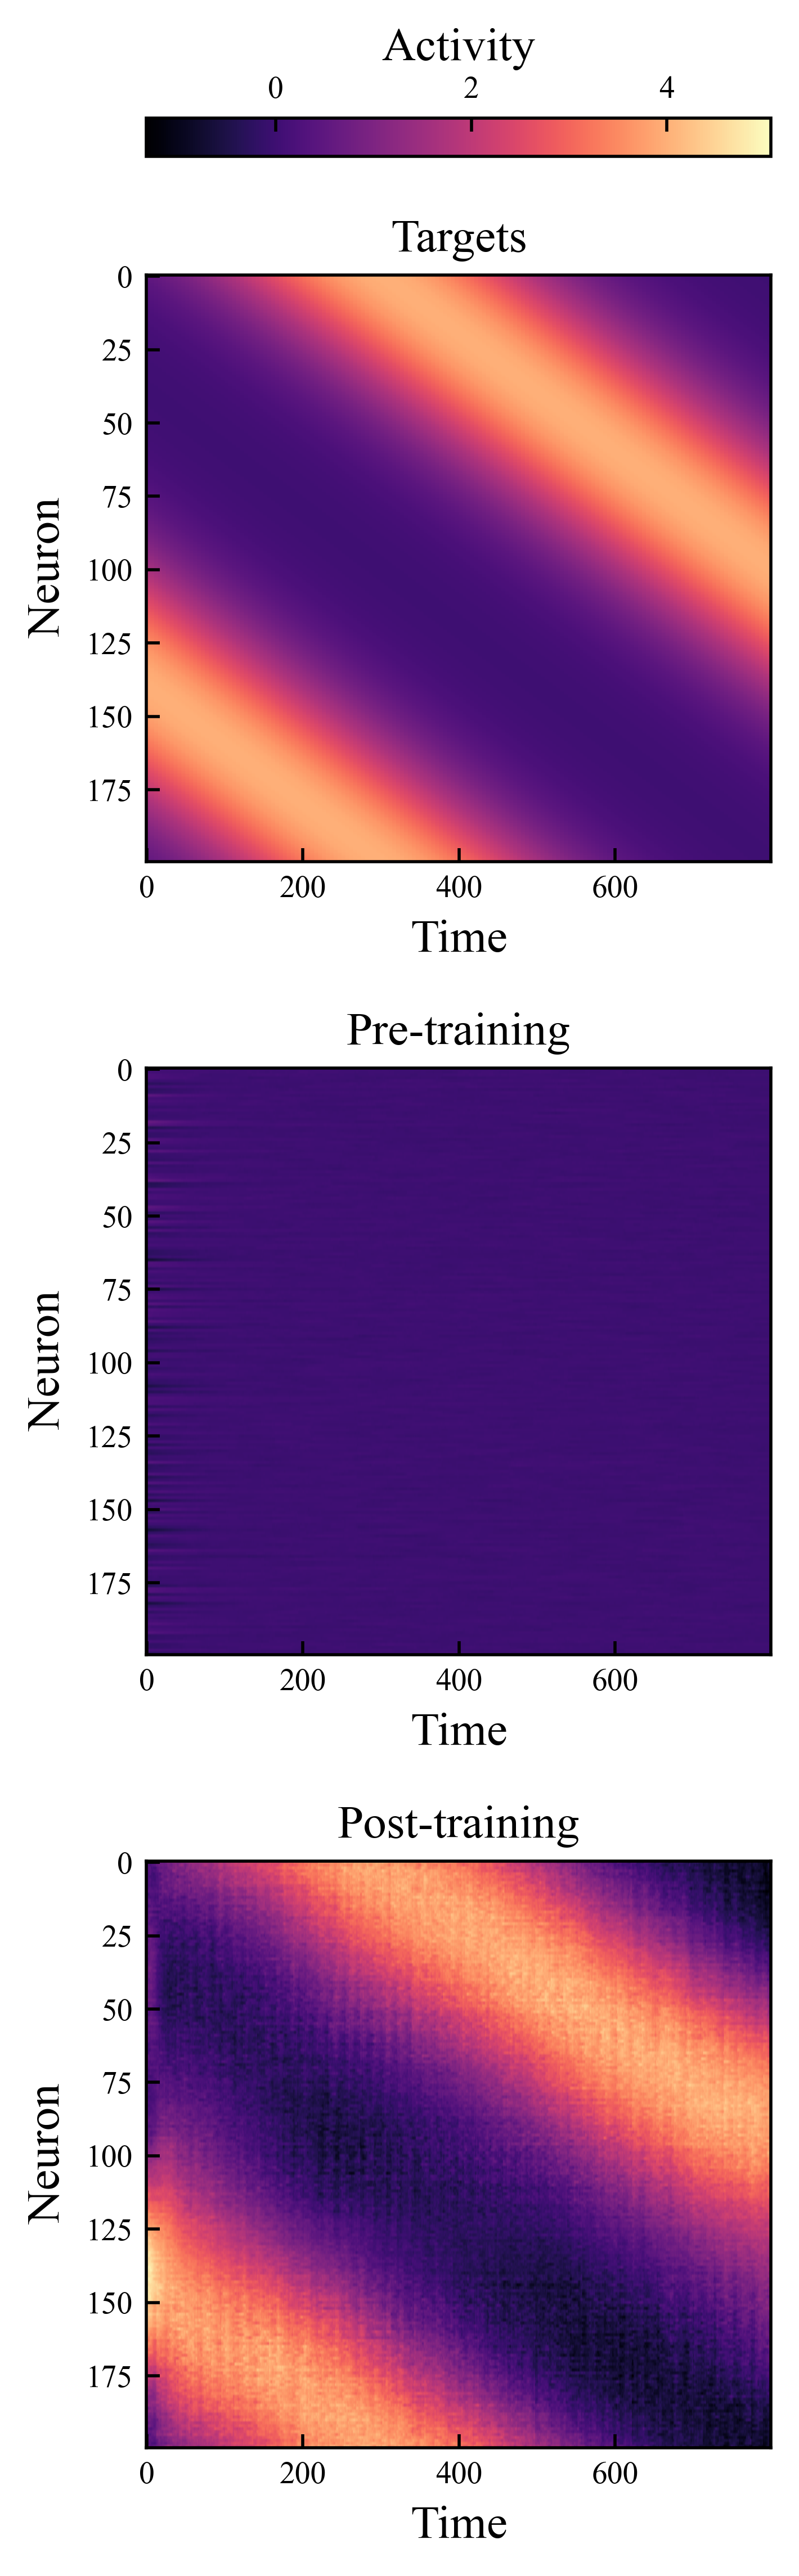

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

idx = 3
pqif = 1
iloop = 14

# Cargar datos
target = pd.read_csv(f'simulation_{idx}/simulacion_{idx}_targets_{pqif}.csv').values
inputs = pd.read_csv(
    f'simulation_{idx}/simulation_{idx}_inputs/simulation_{idx}_inputs_pqif_{pqif}_iloop_{iloop}_seed_0.csv',
    header=None
).values
pretrain_inputs = pd.read_csv(
    f'simulation_{idx}/simulation_{idx}_inputs/simulation_{idx}_inputs_pqif_{pqif}_iloop_0_seed_0.csv',
    header=None
).values

outputs = pd.read_csv(
    f'simulation_{idx}/simulation_{idx}_outputs/simulation_{idx}_outputs_pqif_{pqif}_iloop_{iloop}_seed_0.csv',
    header=None
).values

# Ignorar primeros 200 ms
inputs_rest = np.nan_to_num(inputs[200:, :])
target_rest = np.nan_to_num(target[200:, :])
pretrain_rest = np.nan_to_num(pretrain_inputs[200:, :])
outputs_rest = np.nan_to_num(outputs[200:, :])
# Colormap compartido
vmin = min(pretrain_rest.min(), inputs_rest.min(), target_rest.min())
vmax = max(pretrain_rest.max(), inputs_rest.max(), target_rest.max())

# Tamaño de cada subplot cuadrado
square_size = 3

# Figura con 3 subplots uno encima del otro
fig, axes = plt.subplots(3, 1, figsize=(3, 9))

# Targets
im0 = axes[0].imshow(target_rest.T, cmap='magma', aspect='auto', vmin=vmin, vmax=vmax)
axes[0].set_title('Targets')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Neuron')

# Pretraining
im1 = axes[1].imshow(pretrain_rest.T, cmap='magma', aspect='auto', vmin=vmin, vmax=vmax)
axes[1].set_title('Pre-training')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Neuron')

# Posttraining / Inputs
im2 = axes[2].imshow(inputs_rest.T, cmap='magma', aspect='auto', vmin=vmin, vmax=vmax)
axes[2].set_title('Post-training')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Neuron')

# Ajustar espaciado
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Colorbar horizontal arriba alineada con los mapas
pos0 = axes[0].get_position()
cbar_ax = fig.add_axes([pos0.x0, 0.965, pos0.width, 0.015])
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')

# Mover ticks y label hacia arriba
cbar_ax.xaxis.set_ticks_position('top')
cbar_ax.xaxis.set_label_position('top')
cbar.set_label('Activity')
plt.savefig('h_sequencesKC.svg', dpi=500)
plt.show()

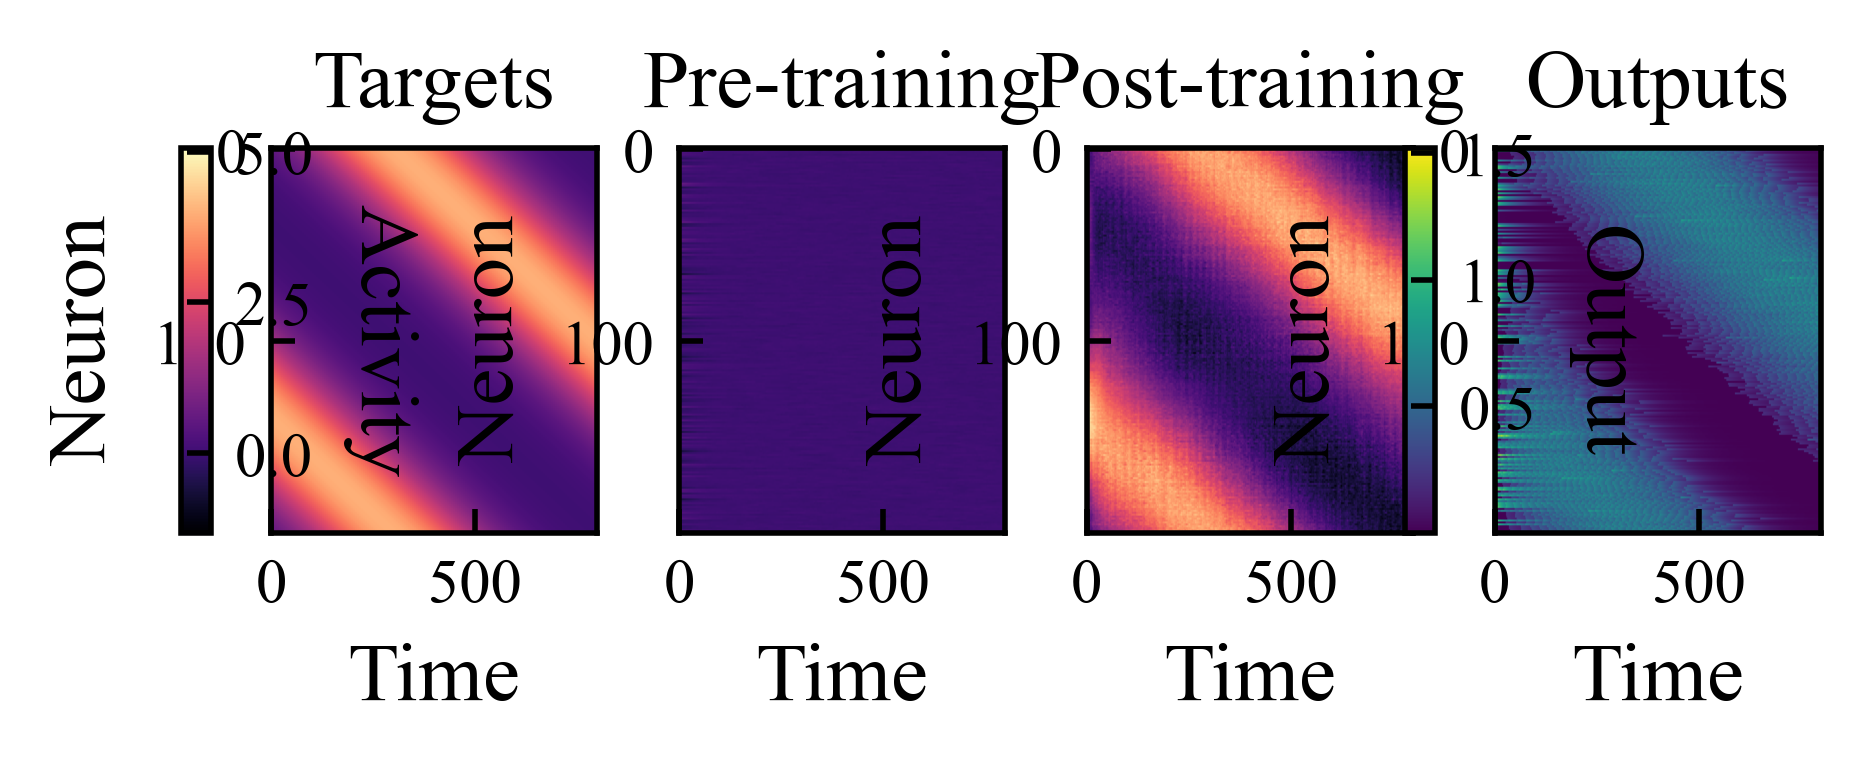

In [35]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# =========================
# FIGURA
# =========================
fig_height = 1
fig_width = 4

fig = plt.figure(figsize=(fig_width, fig_height))
gs = GridSpec(1, 4, wspace=0.25)

ax_tgt = fig.add_subplot(gs[0, 0])
ax_pre = fig.add_subplot(gs[0, 1])
ax_in  = fig.add_subplot(gs[0, 2])
ax_out = fig.add_subplot(gs[0, 3])

# =========================
# TARGETS / PRE / POST (magma)
# =========================
im0 = ax_tgt.imshow(
    target_rest.T, cmap='magma', aspect='auto',
    vmin=vmin, vmax=vmax
)
ax_tgt.set_title('Targets')
ax_tgt.set_xlabel('Time')
ax_tgt.set_ylabel('Neuron')

im1 = ax_pre.imshow(
    pretrain_rest.T, cmap='magma', aspect='auto',
    vmin=vmin, vmax=vmax
)
ax_pre.set_title('Pre-training')
ax_pre.set_xlabel('Time')
ax_pre.set_ylabel('Neuron')

im2 = ax_in.imshow(
    inputs_rest.T, cmap='magma', aspect='auto',
    vmin=vmin, vmax=vmax
)
ax_in.set_title('Post-training')
ax_in.set_xlabel('Time')
ax_in.set_ylabel('Neuron')

# =========================
# OUTPUTS (viridis)
# =========================
im_out = ax_out.imshow(
    outputs_rest.T, cmap='viridis', aspect='auto'
)
ax_out.set_title('Outputs')
ax_out.set_xlabel('Time')
ax_out.set_ylabel('Neuron')

# =========================
# COLORBAR MAGMA (izquierda de Targets)
# =========================
pos_tgt = ax_tgt.get_position()
cax_magma = fig.add_axes([
    pos_tgt.x0 - 0.045,
    pos_tgt.y0,
    0.015,
    pos_tgt.height
])
cbar_magma = fig.colorbar(im2, cax=cax_magma)
cbar_magma.set_label('Activity', rotation=270, labelpad=15)

# =========================
# COLORBAR VIRIDIS (izquierda de Outputs)
# =========================
pos_out = ax_out.get_position()
cax_viridis = fig.add_axes([
    pos_out.x0 - 0.045,
    pos_out.y0,
    0.015,
    pos_out.height
])
cbar_viridis = fig.colorbar(im_out, cax=cax_viridis)
cbar_viridis.set_label('Output', rotation=270, labelpad=15)

plt.savefig('h_sequencesKC.svg', dpi=500)
plt.show()




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


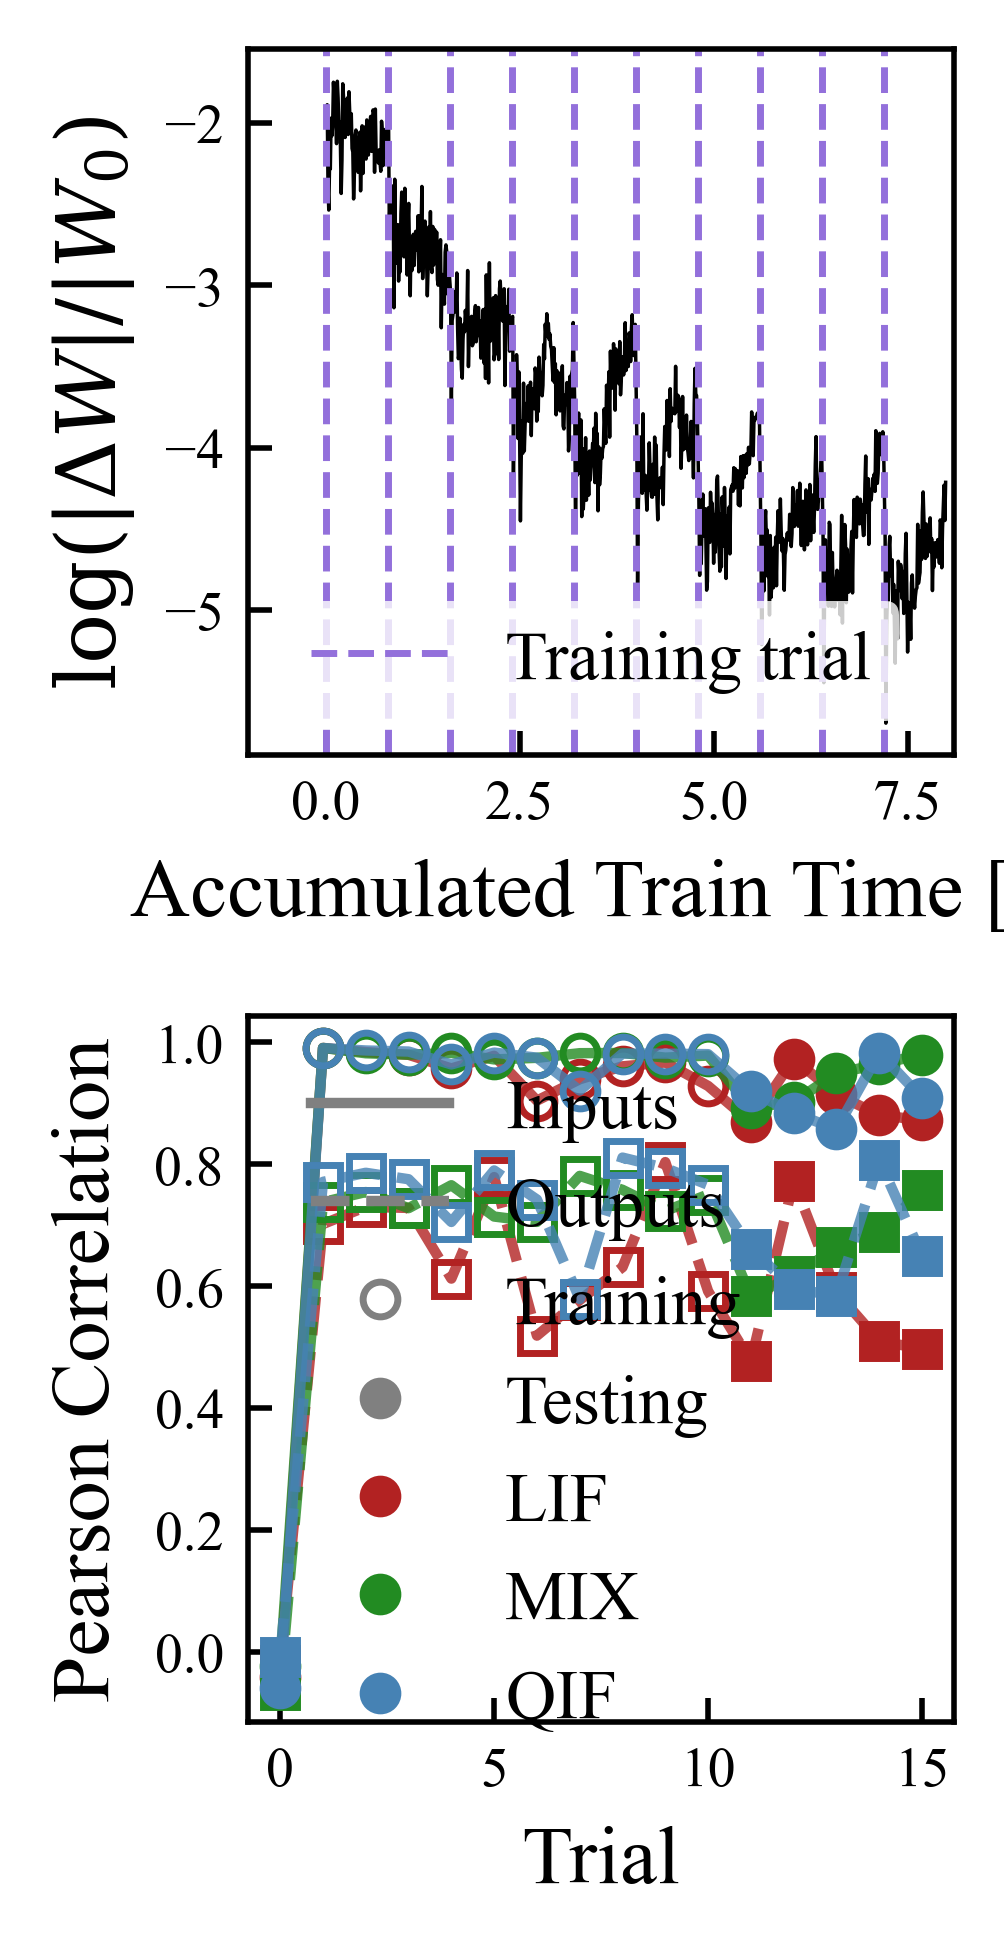

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# ------------------------
# Parámetros
# ------------------------
idx = 3  # Oscillations
xs = [0, 0.5, 1]
colores = ['firebrick', 'forestgreen', 'steelblue']
nombres = ['LIF', 'MIX', 'QIF']

N = 200
itstim = 200
nloop = 16

# ------------------------
# Figura con dos subplots
# (cuadrados y del mismo tamaño)
# ------------------------
fig, axes = plt.subplots(
    2, 1,
    figsize=(2,4),   # alto = 2 × ancho
    sharex=False
)

# Forzar recuadros cuadrados idénticos
for ax in axes:
    ax.set_box_aspect(1)

# ============================================================
# Subplot superior: dW/dt
# ============================================================
from matplotlib.lines import Line2D

ax_dw = axes[0]

dw_csv = pd.read_csv(
    f'simulation_{idx}/simulation_{idx}_dw_pqif_0.5_seed_0.csv'
)
dw_dt = dw_csv.values

ax_dw.plot(
    dw_dt[:, 0] / 1000,
    dw_dt[:, 1],
    color='black',
    linewidth=0.5,
)

# Violet lines indicate training trials
for i in range(10):
    ax_dw.axvline(
        x=i * 0.8,
        color='mediumpurple',
        linestyle='--',
        linewidth=1,
    )

ax_dw.set_xlim(-1, 8.1)
ax_dw.set_ylabel(r'$\log (|\Delta W|/|W_0)$')
ax_dw.set_xlabel('Accumulated Train Time [s]')

# ------------------------
# Leyenda para las líneas violetas con fondo blanco
# ------------------------
training_line = Line2D([0], [0], color='mediumpurple', linestyle='--', linewidth=1, label='Training trial')
ax_dw.legend(handles=[training_line], frameon=True, facecolor='white', edgecolor='none')


# ============================================================
# Subplot inferior: Pearson (inputs y outputs)
# ============================================================
ax_cc = axes[1]

for x, color, nombre in zip(xs, colores, nombres):

    # Targets
    target_csv = pd.read_csv(
        f'simulation_{idx}/simulacion_{idx}_targets_{x}.csv'
    )
    targets = target_csv.values

    cc_in = np.zeros(nloop)
    cc_out = np.zeros(nloop)

    for iloop in range(nloop):
        # INPUTS
        file_in = (
            f'simulation_{idx}/simulation_{idx}_inputs/'
            f'simulation_{idx}_inputs_pqif_{x}_iloop_{iloop}_seed_0.csv'
        )
        df_in = pd.read_csv(file_in, header=None).values

        # OUTPUTS
        file_out = (
            f'simulation_{idx}/simulation_{idx}_outputs/'
            f'simulation_{idx}_outputs_pqif_{x}_iloop_{iloop}_seed_0.csv'
        )
        df_out = pd.read_csv(file_out, header=None).values

        ci_in = np.zeros(N)
        ci_out = np.zeros(N)
        
        for i in range(N):
            # Inputs
            rout_i_in = df_in[:, i]
            if np.var(targets[itstim:, i]) > 0 and np.var(rout_i_in[itstim:]) > 0:
                ci_in[i] = pearsonr(
                    targets[itstim:, i],
                    rout_i_in[itstim:]
                )[0]
            
            # Outputs
            rout_i_out = df_out[:, i]
            if np.var(targets[itstim:, i]) > 0 and np.var(rout_i_out[itstim:]) > 0:
                ci_out[i] = pearsonr(
                    targets[itstim:, i],
                    rout_i_out[itstim:]
                )[0]

        cc_in[iloop] = np.mean(ci_in)
        cc_out[iloop] = np.mean(ci_out)

    # Línea continua INPUTS
    ax_cc.plot(
        np.arange(nloop),
        cc_in,
        color=color,
        linewidth=1.5,
        alpha=0.8
    )
    
    # Línea punteada OUTPUTS
    ax_cc.plot(
        np.arange(nloop),
        cc_out,
        color=color,
        linewidth=1.5,
        alpha=0.8,
        linestyle='--'
    )

    # Train (huecos) - INPUTS
    ax_cc.plot(
        np.arange(1, 11),
        cc_in[1:11],
        'o',
        markersize=5,
        markerfacecolor='none',
        color=color
    )

    # Test (llenos) - INPUTS
    ax_cc.plot(
        np.arange(11, 16),
        cc_in[11:],
        'o',
        markersize=5,
        markerfacecolor=color,
        color=color
    )

    # Iteración 0 - INPUTS
    ax_cc.plot(
        0,
        cc_in[0],
        'o',
        markersize=5,
        color=color,
        label=nombre
    )
    
    # Train (huecos) - OUTPUTS
    ax_cc.plot(
        np.arange(1, 11),
        cc_out[1:11],
        's',
        markersize=5,
        markerfacecolor='none',
        color=color
    )

    # Test (llenos) - OUTPUTS
    ax_cc.plot(
        np.arange(11, 16),
        cc_out[11:],
        's',
        markersize=5,
        markerfacecolor=color,
        color=color
    )

    # Iteración 0 - OUTPUTS
    ax_cc.plot(
        0,
        cc_out[0],
        's',
        markersize=5,
        color=color
    )

ax_cc.set_xlabel('Trial')
ax_cc.set_ylabel('Pearson Correlation')

# Leyenda explicativa
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='grey', linestyle='-', linewidth=1.5, label='Inputs'),
    Line2D([0], [0], color='grey', linestyle='--', linewidth=1.5, label='Outputs'),
    Line2D([0], [0], color='grey', marker='o', markerfacecolor='none', markersize=5, linestyle='', label='Training'),
    Line2D([0], [0], color='grey', marker='o', markerfacecolor='grey', markersize=5, linestyle='', label='Testing')
]
ax_cc.legend(handles=custom_lines + ax_cc.get_legend_handles_labels()[0], frameon=False)


# ------------------------
# Final
# ------------------------
plt.tight_layout(pad=0.8)
plt.savefig('dw_and_pearson_seq_idx3.eps')
plt.savefig('fg_dw_and_pearson_seq_idx3.svg')
plt.show()